<a href="https://colab.research.google.com/github/Priesemann-Group/covid19_inference_forecast/blob/master/scripts/example_script_covid19_inference_complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks run an SEIR-like model. Details can be found in the documentation: https://covid19-inference-forecast.readthedocs.io/en/latest/doc/models.html

##Installation
Run this if the module isn't installed yet or is run in Google Colab

In [1]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference_forecast.git

  Cloning https://github.com/Priesemann-Group/covid19_inference_forecast.git to /tmp/pip-req-build-0uezxyaf
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference_forecast.git /tmp/pip-req-build-0uezxyaf
  Created wheel for covid19-inference: filename=covid19_inference-0.0.5-cp36-none-any.whl size=24176 sha256=69e4ee57682000390072a20af66fe49302496681b101fa4e15cf4d766d26ab13
  Stored in directory: /tmp/pip-ephem-wheel-cache-kfyx7_n_/wheels/52/45/eb/f6f23000e78f72ecc4b7cf6609584ed8a90e447694cfae0317
Successfully built covid19-inference


#Fit Model

In [0]:
import sys
sys.path.append('..')
import datetime

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19

confirmed_cases = cov19.get_jhu_confirmed_cases()

date_data_begin = datetime.datetime(2020,3,1)
date_data_end   = cov19.get_last_date(confirmed_cases)
#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 12 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 14
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, 'Germany',
                                     date_data_begin, date_data_end)

change_points = [dict(pr_mean_date_begin_transient = datetime.datetime(2020,3,9),
                      pr_median_lambda = 1),
                 dict(pr_mean_date_begin_transient = datetime.datetime(2020,3,16),
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.5,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = datetime.datetime(2020,3,23),
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 0.1,
                      pr_sigma_lambda = 0.3)]

model = cov19.SEIR_with_extensions(np.diff(cases_obs),
                                    change_points,
                                    date_begin_sim,
                                    num_days_sim,
                                    diff_data_sim, 
                                   N=83e6,
                                   priors_dict=dict(pr_sigma_random_walk=0.1),
                                   with_random_walk=True)

trace = pm.sample(model=model, init='advi', draws=1000)
# advi is important as initialization, other initializations methods lead
# to more divergences


pr_beta_I_begin was set to default value 100
pr_beta_E_begin_scale was set to default value 10
pr_median_lambda_0 was set to default value 2
pr_sigma_lambda_0 was set to default value 0.7
pr_median_mu was set to default value 0.3333333333333333
pr_sigma_mu was set to default value 0.3
pr_median_delay was set to default value 5
pr_sigma_delay was set to default value 0.2
scale_delay was set to default value 0.3
pr_beta_sigma_obs was set to default value 10
pr_mean_median_incubation was set to default value 5
pr_sigma_median_incubation was set to default value 1
sigma_incubation was set to default value 0.418
pr_sigma_lambda of change point 0 was set to default value 0.7
pr_sigma_date_begin_transient of change point 0 was set to default value 3
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


#Plotting

Text(0, 0.5, 'λ_t_random_walk with 75% CI')

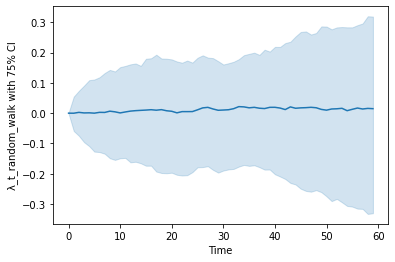

In [0]:
time_arr = np.arange(trace.λ_t_random_walk.shape[1])
plt.plot(time_arr, np.median(trace.λ_t_random_walk, axis=0))
plt.fill_between(time_arr, *np.percentile(trace.λ_t_random_walk, axis=0, q=(12.5,87.5)), color='tab:blue', alpha=0.2)
plt.xlabel('Time')
plt.ylabel('λ_t_random_walk with 75% CI')

Dimension of E_begin larger than one, skipping
Dimension of λ_t_random_walk larger than one, skipping


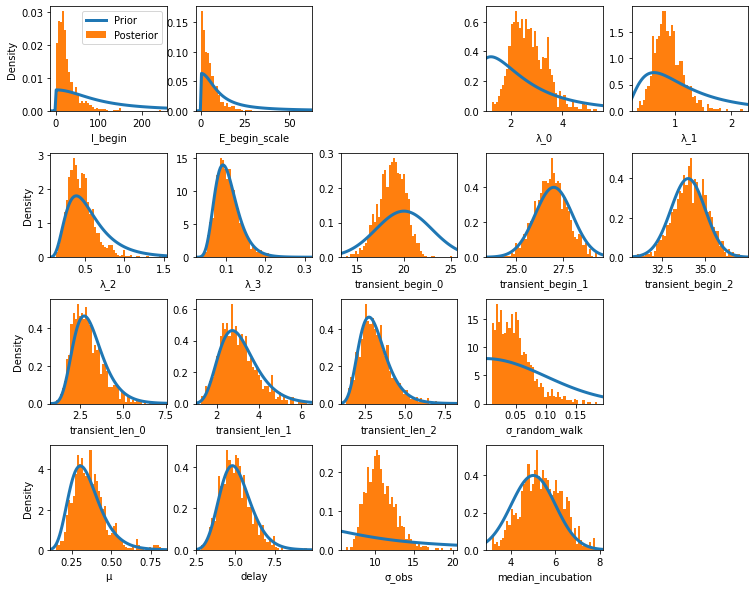

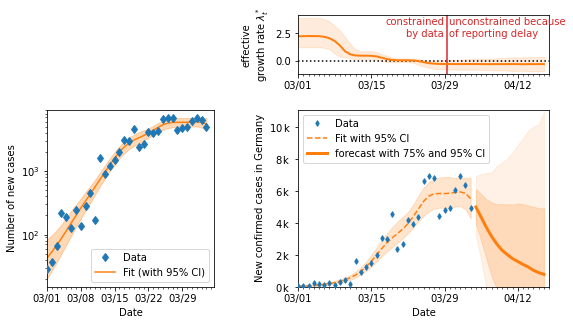

In [0]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax])
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
fig, axes = cov19.plotting.plot_cases(trace, np.diff(cases_obs), date_begin_sim, diff_data_sim)